### Visualize model output weights

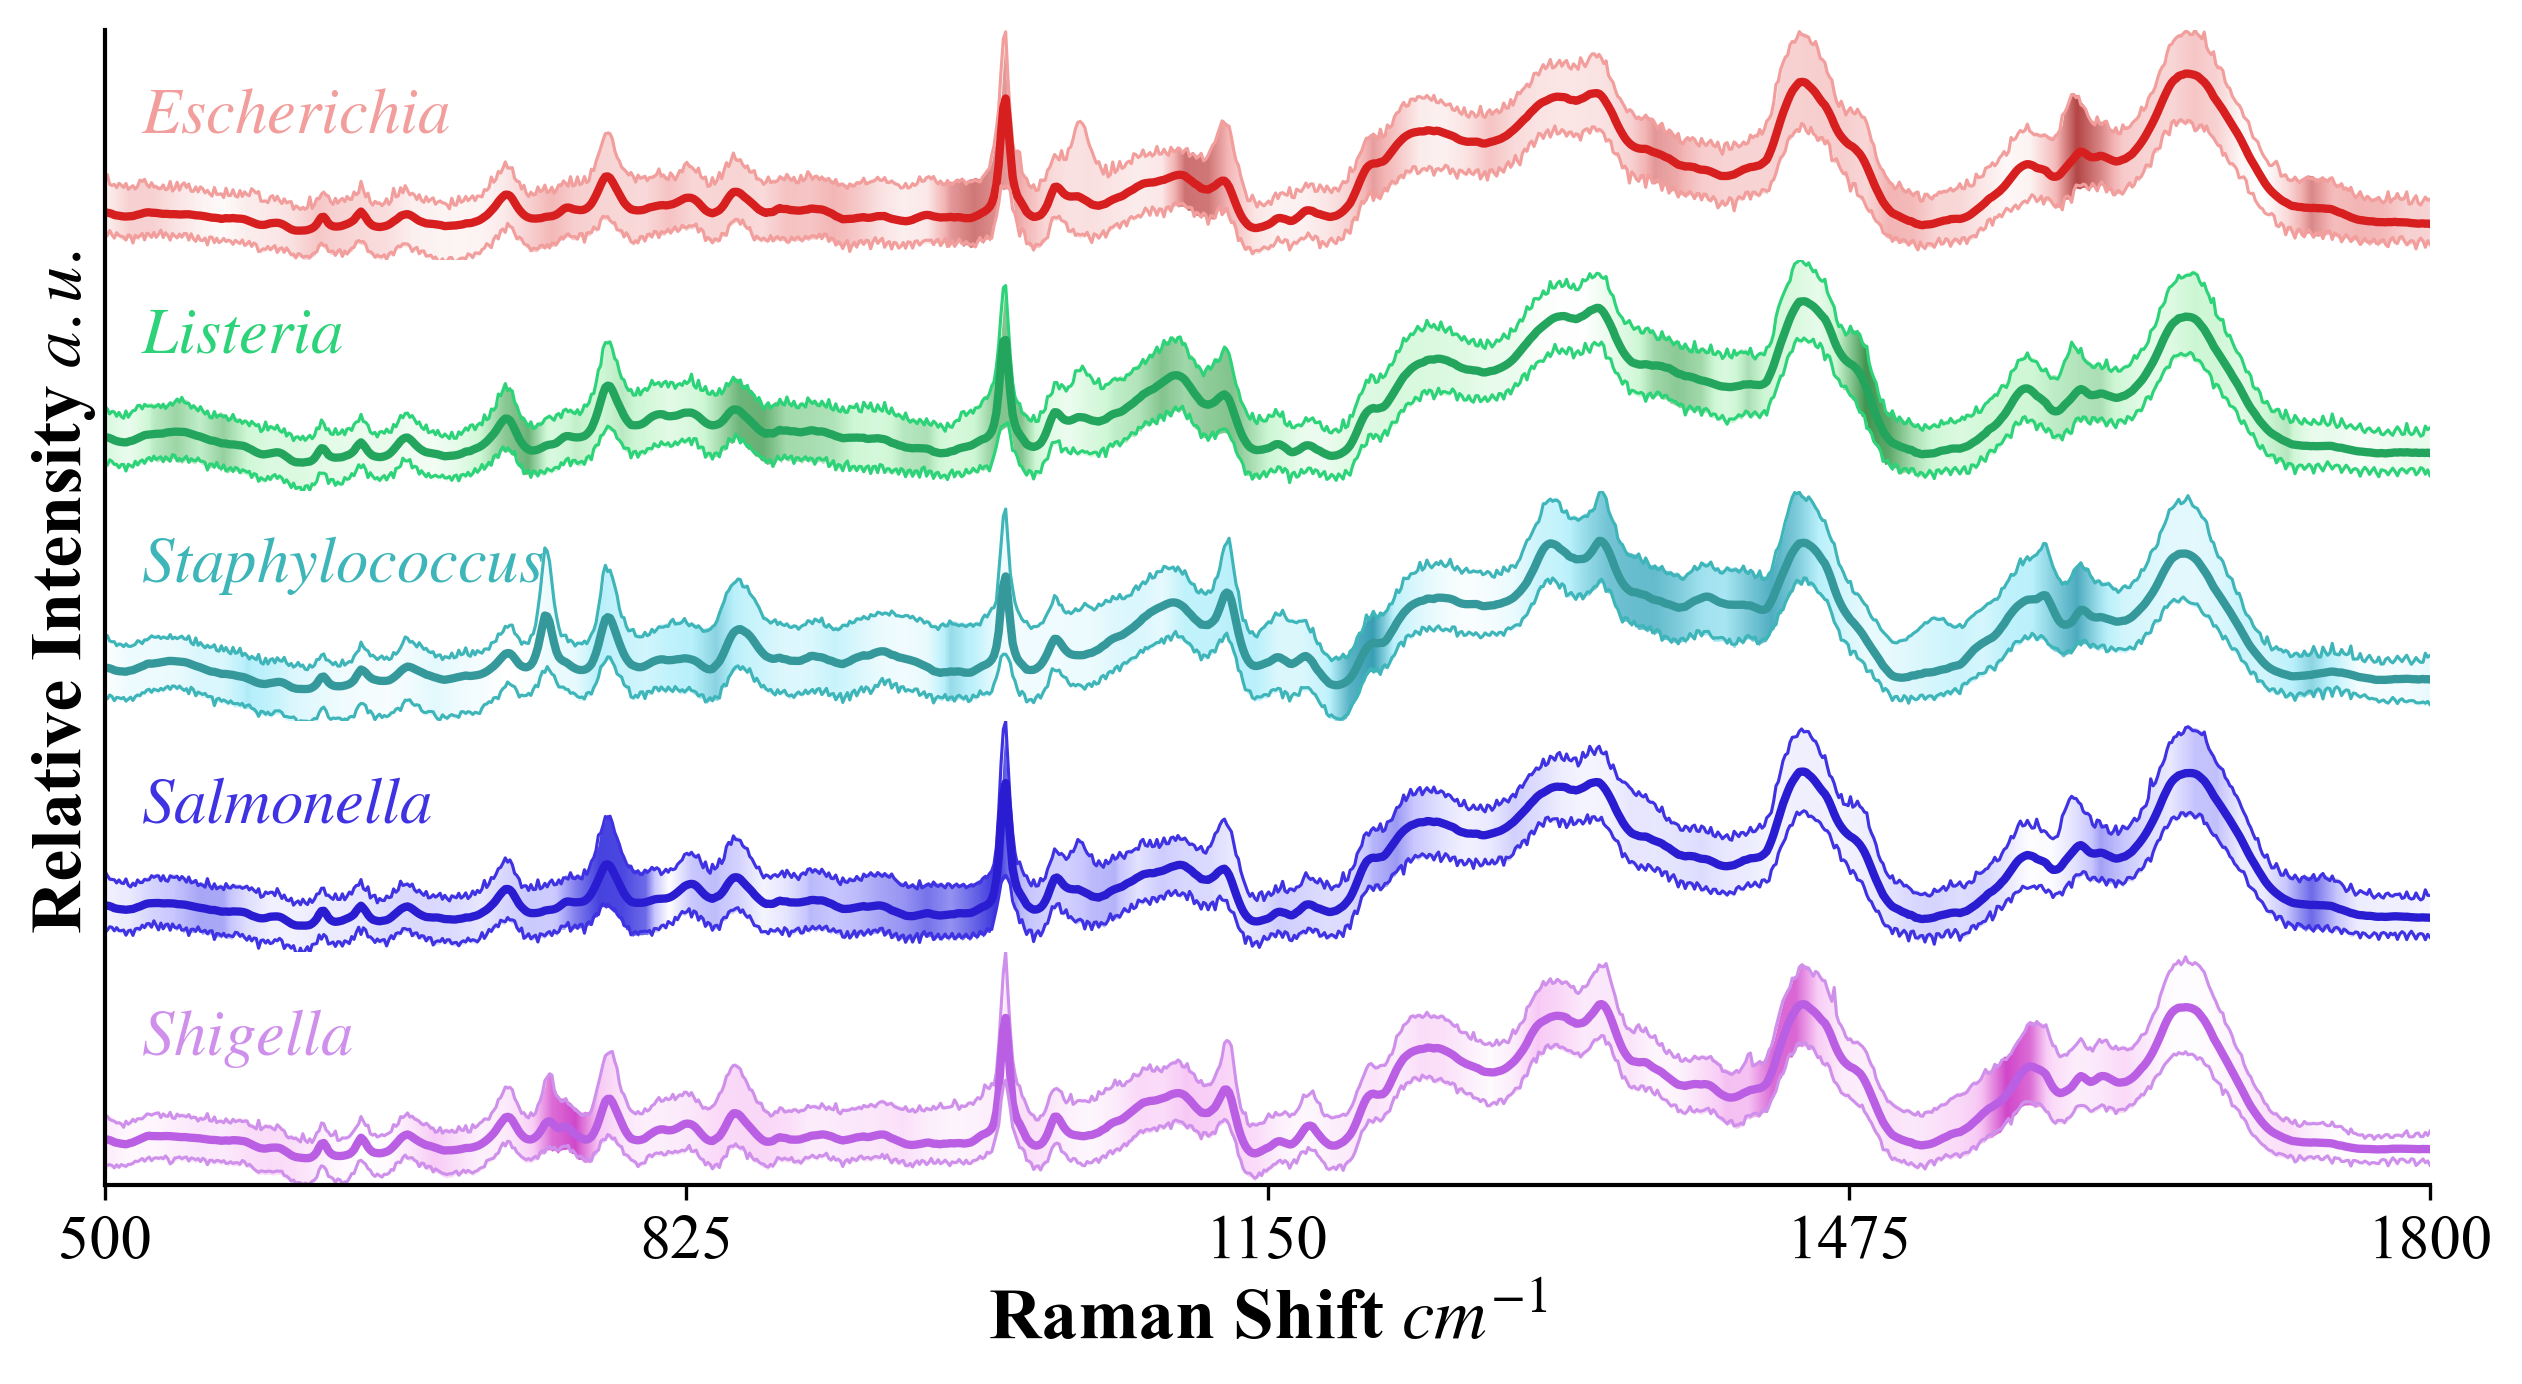

In [1]:
import pandas as pd
import numpy as np
import os
import torch
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.colors as mcolors

plt.rcParams['axes.linewidth'] = 1 
plt.rcParams['figure.dpi'] = 300 
plt.rcParams['mathtext.fontset'] = 'stix' #  formula font
''''''
font = {'family': 'serif',
        'serif': 'Times New Roman', 
        #'weight': 'normal',
        #'size': 10
        }
plt.rc('font', **font)

data_list = {
     'Escherichia coli':{},
     'Listeria monocytogenes':{},
     'Staphylococcus aureus' :{},
     'Salmonella':{},
     'Shigella':{}
}
keys_list = list(data_list.keys()) # 获取键

def load_data(Intensity):
    # Intensity = Intensity - min(Intensity)
    # Intensity = Intensity / (max(Intensity)- min(Intensity)) # 归一化   
    # Intensity = torch.from_numpy(Intensity).to(torch.float32)
    # Intensity = torch.unsqueeze(Intensity,dim=0) 
    return Intensity

# Read the weight csv file and flatten and normalize it
def read_quanzhong(path, num):
    quanzhong_data = pd.read_csv(path, header=None)
    quanzhong = quanzhong_data.values
    all_weights = quanzhong[:,:num+1] # Read the column corresponding to the weight of foodborne pathogens
    all_weights = np.sum(all_weights,axis=1)
    all_weights = all_weights.reshape(1, -1) 
    final_all_weights = (all_weights - np.min(all_weights)) / (np.max(all_weights)  - np.min(all_weights))
    masked_outputs = final_all_weights
    return masked_outputs

def weight_mask(masked_data):
    # Linear interpolation of weight data
    # x_original = np.linspace(300, 2100, np.size(masked_outputs_1, axis=0)) 
    # x_denser = np.linspace(300, 2100, len(raman_shift))
    x_original = np.linspace(500, 1800, np.size(masked_data, axis=0)) 
    x_denser = np.linspace(500, 1800, len(raman_shift))
    f1 = interp1d(x_original, masked_data, kind='linear') 
    data_denser = f1(x_denser)
    data_2d_denser = data_denser.reshape(1, -1) # 插值成1000

    return data_2d_denser

csv_path = '/home/fding/zlwang/Preprocess_data/compression_test_from_pre_data/l22220_Listeria_monocytogenes_1_2c/l22220_____--spectrum--32281--spec.data 1 0957 (35).csv'
csv_data = pd.read_csv(csv_path, header=None)
raman_shift = csv_data.iloc[:,0].values

# Spectral data
csvpath = r'save_csv/otsu_mean.csv'
data = pd.read_csv(csvpath, header=None)
intensity_data = [load_data(data.iloc[i, :].values) for i in range(data.shape[0])]

csvpath = r'save_csv/otsu_max.csv'
max_data = pd.read_csv(csvpath, header=None)
max_intensity_data = [load_data(max_data.iloc[i, :].values) for i in range(max_data.shape[0])]

csvpath = r'save_csv/otsu_min.csv'
min_data = pd.read_csv(csvpath, header=None)
min_intensity_data = [load_data(min_data.iloc[i, :].values) for i in range(min_data.shape[0])]


class_list = [4, 5, 5, 5, 3]
masked_outputs = [
    np.squeeze(read_quanzhong(path=f'save_csv/summed_category_{i+1}.csv', num=class_list[i])) for i in range(5)
]

# Tag List
Bacteria_categories = ['Escherichia','Listeria','Staphylococcus','Salmonella','Shigella']
color_list = ['#F19E9C','#2DD378','#3EB5B8','#3F32E2','#CF90EC']
weight_color_list = ['#D71F1F','#23A55E','#35999B','#2A1DD1','#BA5FE3']

# Weight data
data_2d_denser = [weight_mask(masked_outputs[i]) for i in range(5)]

# Drawing
num_colors = 256
fig, axs = plt.subplots(5,1, figsize=(10, 5))
plt.subplots_adjust(hspace=-0.01)

piclist = []
# Create a normalizer to limit the data range to [0, 1]
norm = mcolors.Normalize(vmin=0, vmax=1)

# Customize a gradient color
cmap_custom_1 = mcolors.LinearSegmentedColormap.from_list('define_1', ['#FFFFFF','#F1A1A1','#A11717'])
cmap_custom_2 = mcolors.LinearSegmentedColormap.from_list('define_2', ['#FFFFFF','#C2F6CB','#127C24'])
cmap_custom_3 = mcolors.LinearSegmentedColormap.from_list('define_3', ['#FFFFFF','#A7EDFB','#0787A1'])
cmap_custom_4 = mcolors.LinearSegmentedColormap.from_list('define_4', ['#FFFFFF','#BAB8FE','#0702D4'])
cmap_custom_5 = mcolors.LinearSegmentedColormap.from_list('define_5', ['#FFFFFF','#F7BFF4','#C519BD'])
cmap_list = [cmap_custom_1, cmap_custom_2, cmap_custom_3, cmap_custom_4, cmap_custom_5]

for i in range(5):
    axs[i].set_ylim(np.min(min_intensity_data[i]), np.max(max_intensity_data[i]))
    axs[i].plot(raman_shift, max_intensity_data[i], color=color_list[i], lw=0.75)
    axs[i].plot(raman_shift, intensity_data[i], color=weight_color_list[i],lw=2)
    axs[i].plot(raman_shift, min_intensity_data[i], color=color_list[i], lw=0.75)
    axs[i].margins(x=0)

    # Optionally disable certain axes
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

    axs[i].set_xticks([])
    axs[i].set_yticks([])

    axs[i].text(520, 0.18,f'${Bacteria_categories[i]}$',fontsize=15.5, color=color_list[i],fontweight= 'bold')

    extent = [500, 1800, np.min(min_intensity_data[i]), np.max(max_intensity_data[i])]
    piclist.append(axs[i].imshow(data_2d_denser[i], norm=norm, cmap=cmap_list[i], alpha=0.8, extent=extent, aspect='auto', interpolation='spline36')) 
    #rainbow Blues YlOrRd
    axs[i].fill_between(raman_shift, np.min(min_intensity_data[i]), min_intensity_data[i]-0.01, color='white')
    axs[i].fill_between(raman_shift, np.max(max_intensity_data[i]), max_intensity_data[i]+0.01, color='white')

axs[4].spines['bottom'].set_visible(True)
axs[4].set_xticks(np.linspace(500, 1800, 5))
axs[4].tick_params( labelsize=15)
axs[4].set_xlabel('Raman Shift ${cm}^{-1}$',fontsize=17.5,fontweight= 'black')

# Convert data coordinates from the coordinate system of a single subplot to the coordinate system of the figure
transFigure = fig.transFigure.inverted() 
xlim_1 = axs[0].get_xlim()
ylim_1 = axs[0].get_ylim()
xlim_3 = axs[4].get_xlim()
ylim_3 = axs[4].get_ylim()
line_x = [xlim_1[0], xlim_3[0]]  # X coordinates
line_y = [ylim_1[1], ylim_3[0]]  # Y coordinates
coord1 = transFigure.transform(axs[0].transData.transform([line_x[0], line_y[0]]))
coord2 = transFigure.transform(axs[4].transData.transform([line_x[1], line_y[1]]))
# Set the line object
line = lines.Line2D((coord1[0], coord2[0]), (coord1[1], coord2[1]), transform=fig.transFigure, color='black', linewidth=1)
fig.lines.append(line)
fig.text(0.1, 0.289, 'Relative Intensity ${a.u.}$', rotation='vertical', fontsize=17.5, fontweight= 'black')
# Color Bar
# cax = fig.add_axes([0.92, 0.25, 0.02, 0.4]) # [left, bottom, width, height]
# cbar = fig.colorbar(piclist[2], cax=cax)
# cbar.set_ticks([0.001, 0.25, 0.5, 0.75, 0.999])
# cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'],fontsize=15.5)

# fig.savefig('save_pic/quanzhong.jpg',dpi=300,bbox_inches='tight')#,pad_inches=0.2
# fig.savefig(zhongwen + '_quanzhong' + '.tif', format="tif",dpi=300,bbox_inches='tight')#,pad_inches=0.2
plt.show()



